# 이상치 확인

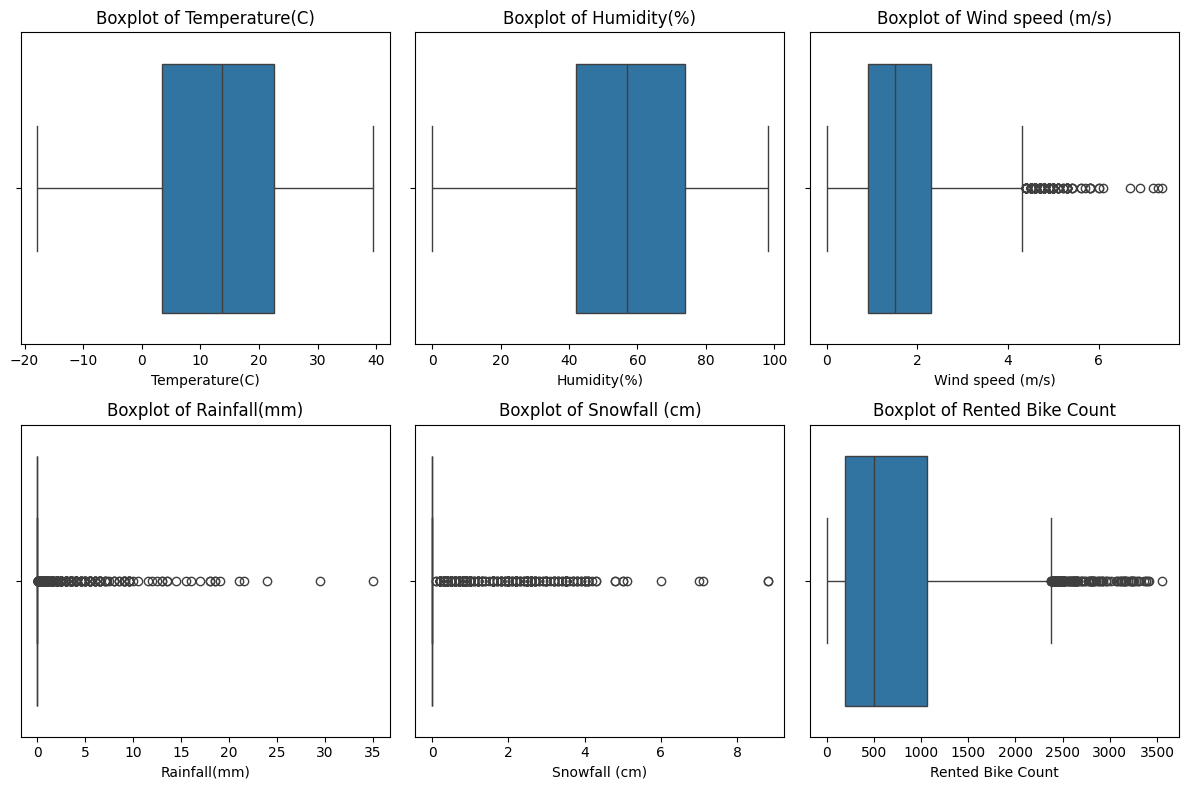

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
df = pd.read_csv('SeoulBikeData.csv')

numeric_columns = ['Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Rainfall(mm)', 'Snowfall (cm)', 'Rented Bike Count']

plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# 서울 자전거 공유 수요 모델

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
df = pd.read_csv('SeoulBikeData.csv')

# 날짜를 datetime으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# 시간(순환성 표시)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# 요일을 구분(0(월) ~ 6(일))
df['Weekday'] = df['Date'].dt.weekday
# 주말을 구분
df['isWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

# 월간(순환성표시)
df['Month'] = df['Date'].dt.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Holiday와 Functioning Day는 0 또는 1로 변환
df['Holiday'] = np.where(df['Holiday'] == 'Holiday', 1, 0)
df['Functioning Day'] = np.where(df['Functioning Day'] == 'Functioning Day', 1, 0)

# 원핫 인코딩
df = pd.get_dummies(df, columns=['Seasons', 'Weekday'])

y = df['Rented Bike Count']
X = df.drop(columns=['Date', 'Rented Bike Count'])

# 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# 훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# 모델 구성
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# 콜백 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath = '/content/Seoul_Bike_sharing_model.keras'

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.25, epochs=2000, batch_size=32, callbacks=[early_stopping_callback, checkpointer]
)

# 테스트 평가
score = model.evaluate(X_test, y_test)
print('Test MSE:', score[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2000
141/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 929745.8125 - mse: 929745.8125
Epoch 1: val_loss improved from inf to 718436.12500, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 928343.9375 - mse: 928343.9375 - val_loss: 718436.1250 - val_mse: 718436.1250
Epoch 2/2000
140/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 621809.0000 - mse: 621809.0000
Epoch 2: val_loss improved from 718436.12500 to 378233.31250, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 618317.3750 - mse: 618317.3750 - val_loss: 378233.3125 - val_mse: 378233.3125
Epoch 3/2000
138/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 370845.2188 - mse: 370845.2188
Epoch 3: val_loss improved from 378233.31250 to 326894.00000, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 370311.9688 - mse: 370311.9688 - val_loss: 326894.0000 - val_mse: 326894.

# 예측결과 MSE : 69862


In [ ]:
# 예측
y_pred = model.predict(X_test)

# 예측 결과
print("예측 값 :", y_pred)

# 실제 값과 비교
print("실제 값 :", y_test.values)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
예측 값 : [[1433.7336 ]
 [ 894.696  ]
 [ 466.57578]
 ...
 [1625.2474 ]
 [ 204.21022]
 [ 300.02524]]
실제 값 : [1728  822  658 ... 1401  169  377]


# 하이퍼파라미터 조정 1

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
df = pd.read_csv('SeoulBikeData.csv')

# 날짜를 datetime으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# 시간(순환성 표시)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# 요일을 구분(0(월) ~ 6(일))
df['Weekday'] = df['Date'].dt.weekday
# 주말을 구분
df['isWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

# 월간(순환성표시)
df['Month'] = df['Date'].dt.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Holiday와 Functioning Day는 0 또는 1로 변환
df['Holiday'] = np.where(df['Holiday'] == 'Holiday', 1, 0)
df['Functioning Day'] = np.where(df['Functioning Day'] == 'Functioning Day', 1, 0)

# 원핫 인코딩
df = pd.get_dummies(df, columns=['Seasons', 'Weekday'])

y = df['Rented Bike Count']
X = df.drop(columns=['Date', 'Rented Bike Count'])

# 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# 훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# 모델 구성
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# 콜백 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath = '/content/Seoul_Bike_sharing_model.keras'

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.25, epochs=2000, batch_size=64, callbacks=[early_stopping_callback, checkpointer]
)

# 테스트 평가
score = model.evaluate(X_test, y_test)
print('Test MSE:', score[1])

Epoch 1/2000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 928259.8750 - mse: 928259.8750
Epoch 1: val_loss improved from inf to 882578.12500, saving model to /content/Seoul_Bike_sharing_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 928159.1875 - mse: 928159.1875 - val_loss: 882578.1250 - val_mse: 882578.1250
Epoch 2/2000
66/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 882220.2500 - mse: 882220.2500
Epoch 2: val_loss improved from 882578.12500 to 773695.37500, saving model to /content/Seoul_Bike_sharing_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 881363.6250 - mse: 881363.6250 - val_loss: 773695.3750 - val_mse: 773695.3750
Epoch 3/2000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 726974.4375 - mse: 726974.4375
Epoch 3: val_loss improved from 773695.37500 to 545977.37500, saving model to /content/Seoul_Bike_sharing_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 726438.0000 - mse: 726438.0000 - val_loss: 545977.3750 - val_mse: 545977.3750
Epoch 4/2000
52/72

# 예측결과2 (배치사이즈 32 -> 16) : MSE : 81249

In [ ]:
# 예측
y_pred = model.predict(X_test)

# 예측 결과
print("예측 값 :", y_pred)

# 실제 값과 비교
print("실제 값 :", y_test.values)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
예측 값 : [[1460.3617 ]
 [ 813.098  ]
 [ 642.8301 ]
 ...
 [1688.9984 ]
 [ 132.41594]
 [ 288.56854]]
실제 값 : [1728  822  658 ... 1401  169  377]


# 예측결과3 (배치사이즈 32 -> 64) MSE: 75429

In [ ]:
# 예측
y_pred = model.predict(X_test)

# 예측 결과
print("예측 값 :", y_pred)

# 실제 값과 비교
print("실제 값 :", y_test.values)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
예측 값 : [[1288.5071 ]
 [ 672.23816]
 [ 436.44907]
 ...
 [1397.703  ]
 [ 161.10564]
 [ 338.82928]]
실제 값 : [1728  822  658 ... 1401  169  377]


# 하이퍼파라미터 조정 2

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
df = pd.read_csv('SeoulBikeData.csv')

# 날짜를 datetime으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# 시간(순환성 표시)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# 요일을 구분(0(월) ~ 6(일))
df['Weekday'] = df['Date'].dt.weekday
# 주말을 구분
df['isWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

# 월간(순환성표시)
df['Month'] = df['Date'].dt.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Holiday와 Functioning Day는 0 또는 1로 변환
df['Holiday'] = np.where(df['Holiday'] == 'Holiday', 1, 0)
df['Functioning Day'] = np.where(df['Functioning Day'] == 'Functioning Day', 1, 0)

# 원핫 인코딩
df = pd.get_dummies(df, columns=['Seasons', 'Weekday'])

y = df['Rented Bike Count']
X = df.drop(columns=['Date', 'Rented Bike Count'])

# 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# 훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# 모델 구성
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# 콜백 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath = '/content/Seoul_Bike_sharing_model.keras'

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.25, epochs=2000, batch_size=32, callbacks=[early_stopping_callback, checkpointer]
)

# 테스트 평가
score = model.evaluate(X_test, y_test)
print('Test MSE:', score[1])

Epoch 1/2000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 807805.2500 - mse: 807805.2500
Epoch 1: val_loss improved from inf to 315549.12500, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 800568.0625 - mse: 800568.0625 - val_loss: 315549.1250 - val_mse: 315549.1250
Epoch 2/2000
137/144 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 291224.6250 - mse: 291224.6250
Epoch 2: val_loss improved from 315549.12500 to 230054.01562, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 289624.4062 - mse: 289624.4062 - val_loss: 230054.0156 - val_mse: 230054.0156
Epoch 3/2000
141/144 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 219113.6875 - mse: 219113.6875
Epoch 3: val_loss improved from 230054.01562 to 205683.51562, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 218916.2188 - mse: 218916.2188 - val_loss: 205683.5156 - val_mse: 205683.5156
Epoch 4/

# 예측결과4 (배치사이즈 32, 은닉층 128, 64, 32) MSE : 64537

In [ ]:
# 예측
y_pred = model.predict(X_test)

# 예측 결과
print("예측 값 :", y_pred)

# 실제 값과 비교
print("실제 값 :", y_test.values)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
예측 값 : [[1615.5347 ]
 [ 688.6575 ]
 [ 670.92993]
 ...
 [1766.16   ]
 [ 158.1001 ]
 [ 299.90952]]
실제 값 : [1728  822  658 ... 1401  169  377]


# 예측결과5 (배치사이즈 32, 은닉층 256, 128, 64) MSE : 57894

In [ ]:
# 예측
y_pred = model.predict(X_test)

# 예측 결과
print("예측 값 :", y_pred)

# 실제 값과 비교
print("실제 값 :", y_test.values)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
예측 값 : [[1605.8401 ]
 [ 741.63464]
 [ 883.52515]
 ...
 [1927.0225 ]
 [ 171.04282]
 [ 386.46875]]
실제 값 : [1728  822  658 ... 1401  169  377]


# 예측결과6 (배치사이즈 32, 은닉층 64, 32, 16) MSE : 73604

In [ ]:
# 예측
y_pred = model.predict(X_test)

# 예측 결과
print("예측 값 :", y_pred)

# 실제 값과 비교
print("실제 값 :", y_test.values)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
예측 값 : [[1343.7268 ]
 [1200.0746 ]
 [ 969.9845 ]
 ...
 [ 960.6835 ]
 [ 166.11778]
 [ 370.4159 ]]
실제 값 : [1728  822  658 ... 1401  169  377]


# 하이퍼파라미터 조정 3

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
df = pd.read_csv('SeoulBikeData.csv')

# 날짜를 datetime으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# 시간(순환성 표시)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# 요일을 구분(0(월) ~ 6(일))
df['Weekday'] = df['Date'].dt.weekday
# 주말을 구분
df['isWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

# 월간(순환성표시)
df['Month'] = df['Date'].dt.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Holiday와 Functioning Day는 0 또는 1로 변환
df['Holiday'] = np.where(df['Holiday'] == 'Holiday', 1, 0)
df['Functioning Day'] = np.where(df['Functioning Day'] == 'Functioning Day', 1, 0)

# 원핫 인코딩
df = pd.get_dummies(df, columns=['Seasons', 'Weekday'])

y = df['Rented Bike Count']
X = df.drop(columns=['Date', 'Rented Bike Count'])

# 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# 훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# 모델 구성
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# 콜백 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath = '/content/Seoul_Bike_sharing_model.keras'

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.25, epochs=2000, batch_size=32, callbacks=[early_stopping_callback, checkpointer]
)

# 테스트 평가
score = model.evaluate(X_test, y_test)
print('Test MSE:', score[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2000
129/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 759288.5000 - mse: 759288.5000
Epoch 1: val_loss improved from inf to 298196.31250, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 739076.2500 - mse: 739076.2500 - val_loss: 298196.3125 - val_mse: 298196.3125
Epoch 2/2000
134/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 268521.9375 - mse: 268521.9375
Epoch 2: val_loss improved from 298196.31250 to 221975.40625, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 267883.6250 - mse: 267883.6250 - val_loss: 221975.4062 - val_mse: 221975.4062
Epoch 3/2000
140/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 222433.2031 - mse: 222433.2031
Epoch 3: val_loss improved from 221975.40625 to 204513.67188, saving model to /content/Seoul_Bike_sharing_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 222464.6094 - mse: 222464.6094 - val_loss: 204513.6719 - val_mse: 204513.

# 예측결과 7 (드롭아웃층 추가) MSE : 68024

In [ ]:
# 예측
y_pred = model.predict(X_test)

# 예측 결과
print("예측 값 :", y_pred)

# 실제 값과 비교
print("실제 값 :", y_test.values)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
예측 값 : [[1298.8502 ]
 [ 758.2489 ]
 [ 645.62146]
 ...
 [1656.5448 ]
 [ 187.82764]
 [ 312.59326]]
실제 값 : [1728  822  658 ... 1401  169  377]


최종코드

# 최종코드

In [ ]:
"""
배치사이즈 : 32
은닉층 : 3개
뉴런개수 : 256, 128, 64
드롭아웃층 : X
"""

import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
df = pd.read_csv('SeoulBikeData.csv')

# 날짜를 datetime으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# 시간(순환성 표시)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# 요일을 구분(0(월) ~ 6(일))
df['Weekday'] = df['Date'].dt.weekday
# 주말을 구분
df['isWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

# 월간(순환성표시)
df['Month'] = df['Date'].dt.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Holiday와 Functioning Day는 0 또는 1로 변환
df['Holiday'] = np.where(df['Holiday'] == 'Holiday', 1, 0)
df['Functioning Day'] = np.where(df['Functioning Day'] == 'Functioning Day', 1, 0)

# 원핫 인코딩
df = pd.get_dummies(df, columns=['Seasons', 'Weekday'])

y = df['Rented Bike Count']
X = df.drop(columns=['Date', 'Rented Bike Count'])

# 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# 훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# 모델 구성
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# 콜백 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath = '/content/Seoul_Bike_sharing_model.keras'

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.25, epochs=2000, batch_size=32, callbacks=[early_stopping_callback, checkpointer]
)

# 테스트 평가
score = model.evaluate(X_test, y_test)
print('Test MSE:', score[1])